In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.utils.np_utils import to_categorical
import datetime

In [ ]:
# fix random seed for reproducibility
np.random.seed(7)
# load the dataset Download from http://www.phy.bme.hu/~torok/airline-passengers.csv
dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset2 = dataframe.values
dataset2 = dataset2.astype('float32')
dataframe.head()

,Passengers
0,112
1,118
2,132
3,129
4,121


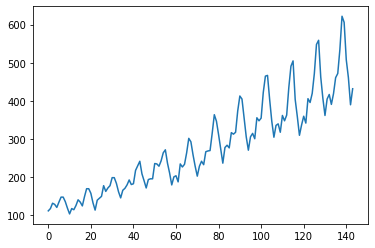

In [ ]:
plt.plot(dataset2)

In [ ]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset2)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 8

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
trainX.shape

(87, 1, 8)

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(20, input_shape=(1, look_back), return_sequences=True))
model.add(LSTM(5))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 1, 20)             2320      
                                                                 
 lstm_12 (LSTM)              (None, 5)                 520       
                                                                 
 dense_13 (Dense)            (None, 1)                 6         
                                                                 
Total params: 2,846
Trainable params: 2,846
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(40, input_shape=(1, look_back)))
model.add(Dense(20))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 40)                7840      
                                                                 
 dense_14 (Dense)            (None, 20)                820       
                                                                 
 dense_15 (Dense)            (None, 1)                 21        
                                                                 
Total params: 8,681
Trainable params: 8,681
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=1)

Epoch 1/50
87/87 [==============================] - 2s 3ms/step - loss: 0.0086
Epoch 2/50
87/87 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 3/50
87/87 [==============================] - 0s 4ms/step - loss: 0.0043
Epoch 4/50
87/87 [==============================] - 0s 4ms/step - loss: 0.0036
Epoch 5/50
87/87 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 6/50
87/87 [==============================] - 0s 4ms/step - loss: 0.0031
Epoch 7/50
87/87 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 8/50
87/87 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 9/50
87/87 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 10/50
87/87 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 11/50
87/87 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 12/50
87/87 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 13/50
87/87 [==============================

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
sc_trainPredict = scaler.inverse_transform(trainPredict)
sc_trainY = scaler.inverse_transform([trainY])
sc_testPredict = scaler.inverse_transform(testPredict)
sc_testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(sc_trainY[0], sc_trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(sc_testY[0], sc_testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(sc_trainPredict)+look_back, :] = sc_trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(sc_trainPredict)+(look_back*2)+1:len(dataset)-1, :] = sc_testPredict

2/2 [==============================] - 0s 4ms/step
Train Score: 21.05 RMSE
Test Score: 43.28 RMSE


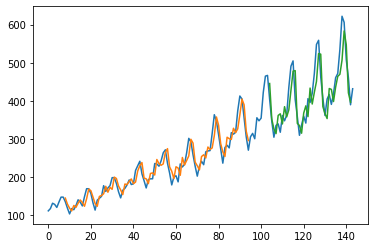

In [ ]:
plt.plot(dataset2)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
tmptrain = np.array([np.copy(trainX[-1])])
L = len(testX)
res = np.zeros(2*L+len(trainX)+look_back*2,dtype=float)
res[:] = np.nan
for i in range(2*L):
    pr = model.predict(np.array(tmptrain))
    #print(scaler.inverse_transform(pr),pr)
    res[len(trainX) + look_back + i] = scaler.inverse_transform(pr)[0]
    #print(tmptrain,pr,res[i])
    tmptrain[0,0,:-1] = tmptrain[0,0,1:]
    tmptrain[0,0,-1] = pr[0]


1/1 [==============================] - 0s 23ms/step


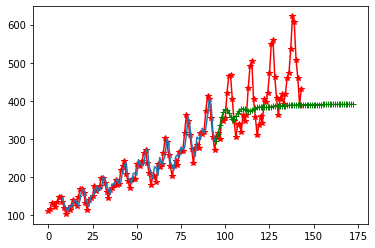

In [ ]:
plt.plot(scaler.inverse_transform(dataset),"r-*")
plt.plot(trainPredictPlot)
plt.plot(res,"g-+")
plt.show()

In [ ]:
tmptrain = np.array([np.copy(trainX[0])])
L = len(dataset) - look_back
res = np.zeros(L+look_back,dtype=float)
res[:] = np.nan
for i in range(L):
    pr = model.predict(np.array(tmptrain))
    #print(scaler.inverse_transform(pr),pr)
    res[look_back + i] = scaler.inverse_transform(pr)[0]
    #print(tmptrain,pr,res[i])
    tmptrain[0,0,:-1] = tmptrain[0,0,1:]
    tmptrain[0,0,-1] = pr[0]



1/1 [==============================] - 0s 23ms/step


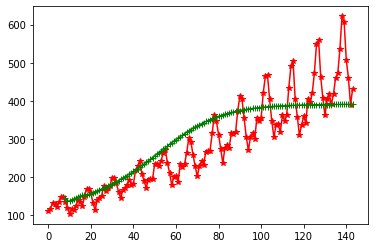

In [ ]:
plt.plot(scaler.inverse_transform(dataset),"r-*")
plt.plot(res,"g-+")
plt.show()

### TASK 1
Predicting the temperatures in Stockholm
 1. Download the file <a href="http://www.phy.bme.hu/~torok/stockholm_temperatures.dat">http://www.phy.bme.hu/~torok/stockholm_temperatures.dat</a>
 2. The file has four columns: year month day temperature separated by tab <code>'\t'</code>. The data starts at 01.01.1800.
 3. Create monthly averages: the new array should contain: year month temperature (averaged)
 4. Take the first 180 years for the training data with given look_back
 5. Create an LSTM network and train it.
 6. Predict the last 31 years
 7. Plot the prediction against the original data.
 8. Predict the last 31 years using always the the predicted values as basis, compare it with the previous test.
 9. Repeat the same experiment with a dense network (note that you may need to flatten the data). Observe the differences in the prediction with both look_back smaller and larger than 12

In [ ]:
raw_data = read_csv('stockholm_temperatures.dat', delimiter = '\t', header = None)
raw_data.columns = ["Year", "Month", "Day", "Temperature"]

raw_data

,Year,Month,Day,Temperature
0,1800,1,1,-6.1
1,1800,1,2,-15.4
2,1800,1,3,-15.0
3,1800,1,4,-19.3
4,1800,1,5,-16.8
...,...,...,...,...
77426,2011,12,27,8.3
77427,2011,12,28,2.6
77428,2011,12,29,4.9
77429,2011,12,30,0.6


In [ ]:
data = raw_data.drop(columns = "Day")
data = data.groupby(['Year', 'Month']).mean()

data

Temperature
Year Month             
1800 1        -6.219355
     2        -6.996429
     3        -6.174194
     4         5.206667
     5         9.248387
...                 ...
2011 8        17.429032
     9        14.036667
     10        8.516129
     11        6.096667
     12        2.506452

[2544 rows x 1 columns]

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data)
# split into train and test sets
train_size = 180 * 12
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 12

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(40, input_shape=(1, look_back)))
model.add(Dense(20))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 40)                8480      
                                                                 
 dense_24 (Dense)            (None, 20)                820       
                                                                 
 dense_25 (Dense)            (None, 1)                 21        
                                                                 
Total params: 9,321
Trainable params: 9,321
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=1)

Epoch 1/25
2147/2147 [==============================] - 9s 4ms/step - loss: 0.0035
Epoch 2/25
2147/2147 [==============================] - 7s 3ms/step - loss: 0.0035
Epoch 3/25
2147/2147 [==============================] - 7s 3ms/step - loss: 0.0034
Epoch 4/25
2147/2147 [==============================] - 7s 3ms/step - loss: 0.0034
Epoch 5/25
2147/2147 [==============================] - 6s 3ms/step - loss: 0.0034
Epoch 6/25
2147/2147 [==============================] - 7s 3ms/step - loss: 0.0034
Epoch 7/25
2147/2147 [==============================] - 6s 3ms/step - loss: 0.0034
Epoch 8/25
2147/2147 [==============================] - 8s 4ms/step - loss: 0.0034
Epoch 9/25
2147/2147 [==============================] - 6s 3ms/step - loss: 0.0034
Epoch 10/25
2147/2147 [==============================] - 6s 3ms/step - loss: 0.0034
Epoch 11/25
2147/2147 [==============================] - 6s 3ms/step - loss: 0.0034
Epoch 12/25
2147/2147 [==============================] - 6s 3ms/step - loss: 0.0034
E

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
sc_trainPredict = scaler.inverse_transform(trainPredict)
sc_trainY = scaler.inverse_transform([trainY])
sc_testPredict = scaler.inverse_transform(testPredict)
sc_testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(sc_trainY[0], sc_trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(sc_testY[0], sc_testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(sc_trainPredict)+look_back, :] = sc_trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(sc_trainPredict)+(look_back*2)+1:len(dataset)-1, :] = sc_testPredict

12/12 [==============================] - 0s 2ms/step
Train Score: 2.02 RMSE
Test Score: 2.12 RMSE


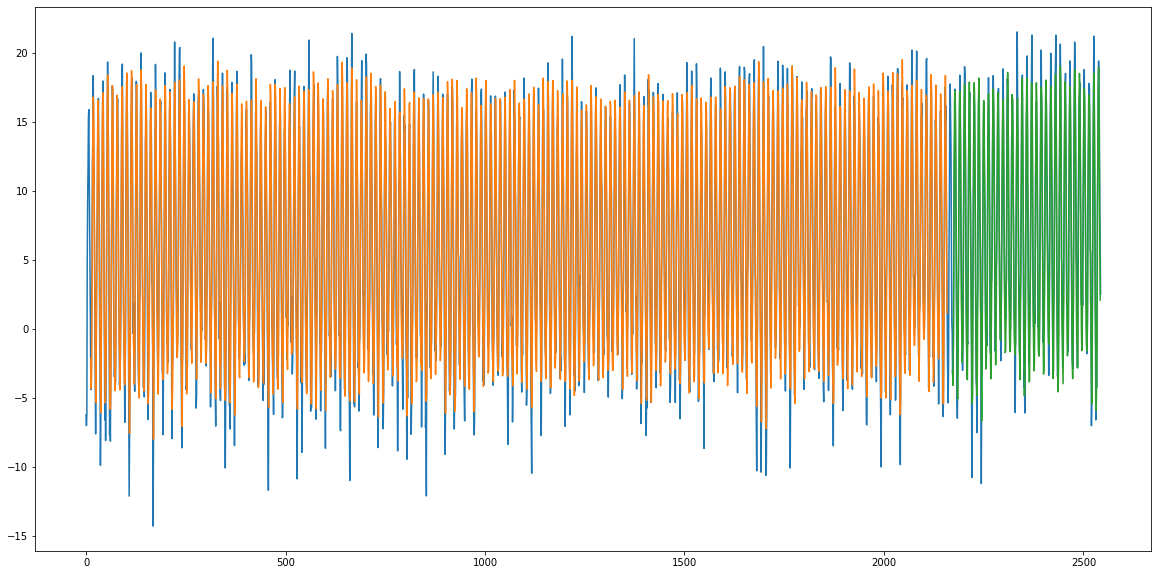

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(data.values)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
tmptrain = np.array([np.copy(trainX[-1])])
L = len(testX)
res = np.zeros(L+len(trainX)+look_back*2,dtype=float)
res[:] = np.nan
for i in range(L):
    pr = model.predict(np.array(tmptrain))
    res[len(trainX) + look_back + i] = scaler.inverse_transform(pr)[0]
    tmptrain[0,0,:-1] = tmptrain[0,0,1:]
    tmptrain[0,0,-1] = pr[0]

1/1 [==============================] - 0s 19ms/step


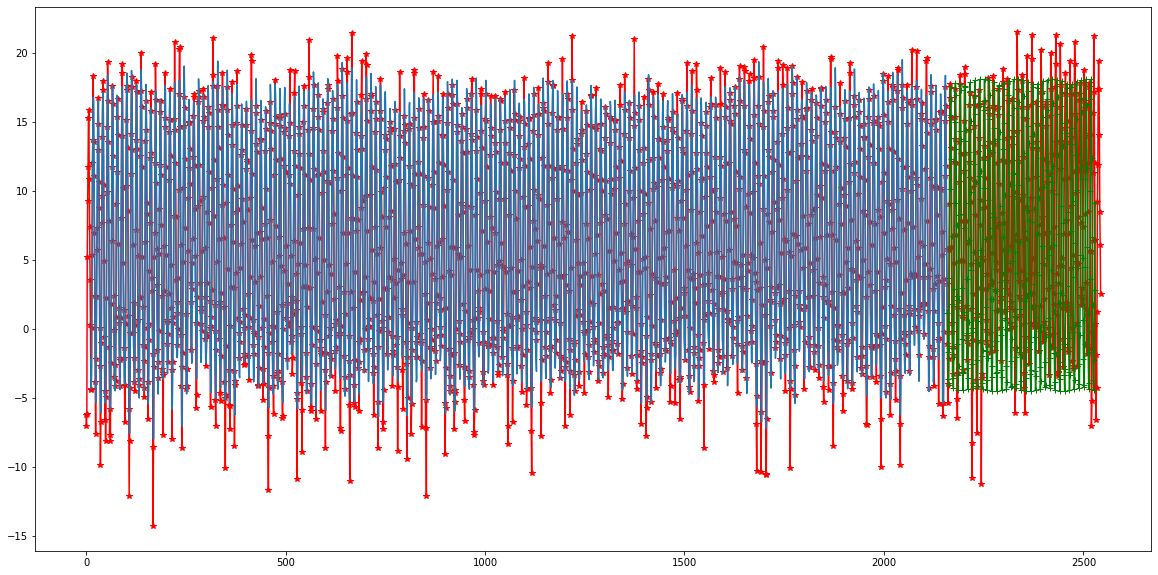

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(dataset),"r-*")
plt.plot(trainPredictPlot)
plt.plot(res,"g-+")
plt.show()

### TASK 2
Predicting the results of Bundesliga
 1. Download the file <a href="http://www.phy.bme.hu/~torok/Bundesliga1819.csv">http://www.phy.bme.hu/~torok/Bundesliga1819.csv</a>
 2. The data has four columns separated by comma: Home team, Away team, Score of home team, Score of away team
 3. Create dataset with `K = look_back` parameter where the data contains the `K` results of a given team. Use one hot encoding for draw/win/loose. Target is the perofrmance in the next match
 4. Train the data using the rounds 3-30
 5. Test the predictions on the remaining 4 rounds
 6. Optional: Below there is a small function which creates the Tabelle of the championship. Include the positions of the two teams in the input data and repeat the same experiment.

In [ ]:
data = read_csv('Bundesliga1819.csv')

data

,HomeTeam,AwayTeam,FTHG,FTAG
0,Bayern Munich,Hoffenheim,3,1
1,Fortuna Dusseldorf,Augsburg,1,2
2,Freiburg,Ein Frankfurt,0,2
3,Hertha,Nurnberg,1,0
4,M'gladbach,Leverkusen,2,0
...,...,...,...,...
301,Mainz,Hoffenheim,4,2
302,M'gladbach,Dortmund,0,2
303,Schalke 04,Stuttgart,0,0
304,Werder Bremen,RB Leipzig,2,1


In [ ]:
teams = list(set(data['HomeTeam']))
NT = len(teams)

teams

['Hannover',
 'Augsburg',
 'Werder Bremen',
 'Bayern Munich',
 'Mainz',
 'Leverkusen',
 'Hoffenheim',
 'Nurnberg',
 'Schalke 04',
 'Fortuna Dusseldorf',
 'Hertha',
 'Freiburg',
 "M'gladbach",
 'Wolfsburg',
 'Dortmund',
 'Stuttgart',
 'Ein Frankfurt',
 'RB Leipzig']

In [ ]:
results = np.zeros((NT, (NT - 1) * 2, 3))
games_per_round = NT / 2

for i in range(len(data.values)):
  round = math.floor(i / (NT / 2))
  home, away, home_goals, away_goals = data.values[i]

  results[teams.index(home)][round] = [home_goals - away_goals > 0, home_goals - away_goals == 0, home_goals - away_goals < 0]
  results[teams.index(away)][round] = [home_goals - away_goals < 0, home_goals - away_goals == 0, home_goals - away_goals > 0]

In [ ]:
teams = set()
for line in data[1:]:
    teams.add(line.split(",")[0])

In [ ]:
teams = list(teams)
NT = len(teams)

teams

['Hannover',
 'Augsburg',
 'Werder Bremen',
 'Bayern Munich',
 'Mainz',
 'Leverkusen',
 'Hoffenheim',
 'Nurnberg',
 'Schalke 04',
 'Fortuna Dusseldorf',
 'Hertha',
 'Freiburg',
 "M'gladbach",
 'Wolfsburg',
 'Dortmund',
 'Stuttgart',
 'Ein Frankfurt',
 'RB Leipzig']

In [ ]:
tabelle = np.zeros(NT, dtype=int)

In [ ]:
#Updates the tabelle using a line from the data
def set_tabelle(tabelle, line):
    f = line.rstrip('\n').split(",")
    t0 = teams.index(f[0])
    t1 = teams.index(f[1])
    g0 = int(f[2])
    g1 = int(f[3])
    if g0 == g1:
        tabelle[t0] += 1
        tabelle[t1] += 1
    elif g0 > g1:
        tabelle[t0] += 3
    else:
        tabelle[t1] += 3

In [ ]:
def team_position(tabelle, team):
    return np.where((-tabelle).argsort() == team)[0][0]